# Optimizing Airport Gate Allocation: A 3D Analytics Approach

**By: [Your Name]**
**Role: Senior Data Scientist**

---

## 1. Introduction: The Business & Operational Challenge

### The Business Problem
Airports are highly constrained environments. Two of the most critical variables in airport management are **Flights** (Demand) and **Gates** (Resources). 
-   **Demand:** Flights arrive and depart on tight schedules with varying passenger loads.
-   **Supply:** There are a limited number of physical gates available, each with a different distance to the exit.

Inefficient gate assignment leads to two major negative outcomes:
1.  **Operational Risk:** If schedules are poorly managed, flights may overlap at the same gate, causing delays (ground stops).
2.  **Passenger Dissatisfaction & Fatigue:** Assigning large planes (High Pax) to distant gates (High Distance) drastically increases the global walking distance.

### The Goal
Our objective is to assign every flight to a specific gate such that:
1.  **Safety Constraint:** No two flights occupy the same gate at the same time.
2.  **Efficiency Objective:** Minimize the **Total Passenger Walking Distance** (Passenger-Meters).

### Why Optimization?
With 20 flights and 5 gates, the number of possible combinations is astronomical ($5^{20} \approx 95 \text{ Trillion}$). A human controller cannot mentally check all valid combinations.
**Integer Linear Programming (ILP)** allows us to mathematically guarantee the *optimal* solution in seconds.



In [1]:
# 2. Setup and Synthetic Data Generation
# We will simulate a busy operational day.

import pandas as pd
import pulp
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting tool
import seaborn as sns

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# --- A. Create Gates (The Supply) ---
# We have 5 Gates with varying distances to the main exit/concourse.
gates_dict = {
    'Gate_ID': ['G1', 'G2', 'G3', 'G4', 'G5'],
    'Distance_m': [100, 300, 500, 700, 1000]
}
df_gates = pd.DataFrame(gates_dict)

# --- B. Create Flights (The Demand) ---
# We generate 20 flights (F101 to F120).
num_flights = 15
flights_data = []

for i in range(num_flights):
    flight_id = f"F{101+i}"
    
    # Arrival Time: Random minute of the day (focus on 08:00 - 20:00)
    arrival = random.randint(480, 1200)
    
    # Turnaround Time (Duration): 45 to 120 minutes
    duration = random.randint(45, 120)
    
    departure = arrival + duration
    
    # Passengers: 50 (Regional Jet) to 250 (Airbus A321/Boeing 757)
    passengers = random.randint(50, 250)
    
    flights_data.append({
        'Flight_ID': flight_id,
        'Arrival': arrival,
        'Departure': departure,
        'Duration': duration,
        'Passengers': passengers
    })

df_flights = pd.DataFrame(flights_data)

print(f"Generated {num_flights} flights and {len(df_gates)} gates.")
display(df_gates)
display(df_flights.head())


Generated 15 flights and 5 gates.


,Gate_ID,Distance_m
0,G1,100
1,G2,300
2,G3,500
3,G4,700
4,G5,1000


,Flight_ID,Arrival,Departure,Duration,Passengers
0,F101,1134,1193,59,56
1,F102,761,837,76,107
2,F103,622,680,58,223
3,F104,1038,1094,56,201
4,F105,912,961,49,57


In [2]:
# 3. The Conflict Matrix (Pre-processing)
# Before running the solver, we must identify which flights CANNOT coincide.

def check_overlap(row_a, row_b):
    # Returns True if the time windows overlap
    buffer = 15 # Required separation time between flights
    start_a, end_a = row_a['Arrival'], row_a['Departure'] + buffer
    start_b, end_b = row_b['Arrival'], row_b['Departure'] + buffer
    
    return (start_a < end_b) and (start_b < end_a)

incompatible_pairs = []

for i in range(len(df_flights)):
    for j in range(i + 1, len(df_flights)):
        flight_a = df_flights.iloc[i]
        flight_b = df_flights.iloc[j]
        
        if check_overlap(flight_a, flight_b):
            incompatible_pairs.append( (flight_a['Flight_ID'], flight_b['Flight_ID']) )

print(f"Total Conflicts Identified: {len(incompatible_pairs)} pairs.")
print("Sample Conflicts:", incompatible_pairs[:3])


Total Conflicts Identified: 26 pairs.
Sample Conflicts: [('F102', 'F108'), ('F102', 'F109'), ('F102', 'F110')]


## 4. The Mathematical Model (Integer Linear Programming)

### Decision Variable
We define a binary variable $x_{i,j}$ for every Flight $i$ and Gate $j$:
$$
x_{i,j} = \begin{cases} 
1 & \text{if Flight } i \text{ is assigned to Gate } j \\
0 & \text{otherwise}
\end{cases}
$$

### Objective Function
We want to minimize the total walking distance. The cost of assigning Flight $i$ to Gate $j$ is $(Passengers_i \times Distance_j)$.
$$
\text{Minimize } Z = \sum_{i} \sum_{j} (x_{i,j} \cdot \text{Passengers}_i \cdot \text{Distance}_j)
$$

### Constraints
1.  **Assignment Constraint:** Every flight $i$ must be assigned to **exactly one** gate.
    $$ \sum_{j} x_{i,j} = 1 \quad \forall i $$

2.  **Conflict Constraint:** For any pair of overlapping flights $(A, B)$, they cannot share gate $j$.
    $$ x_{A,j} + x_{B,j} \le 1 \quad \forall j, \forall (A, B) \in \text{Conflicts} $$



In [3]:
# Implementation using PuLP

prob = pulp.LpProblem("Airport_Gate_Optimization", pulp.LpMinimize)

# Decision Variables
flights = df_flights['Flight_ID'].tolist()
gates = df_gates['Gate_ID'].tolist()
x = pulp.LpVariable.dicts("x", (flights, gates), cat='Binary')

# Objective Function
objective_terms = []
for idx, f_row in df_flights.iterrows():
    f_id = f_row['Flight_ID']
    pax = f_row['Passengers']
    for _, g_row in df_gates.iterrows():
        g_id = g_row['Gate_ID']
        dist = g_row['Distance_m']
        objective_terms.append(x[f_id][g_id] * pax * dist)

prob += pulp.lpSum(objective_terms)

# Constraints
# 1. Every flight needs 1 gate
for f in flights:
    prob += pulp.lpSum([x[f][g] for g in gates]) == 1, f"Must_Assign_{f}"

# 2. No overlapping flights at same gate
for (fa, fb) in incompatible_pairs:
    for g in gates:
        prob += x[fa][g] + x[fb][g] <= 1, f"No_Overlap_{fa}_{fb}_{g}"

# Solve
prob.solve()
print("Solver Status:", pulp.LpStatus[prob.status])
print(f"Optimal Total Walking Distance: {pulp.value(prob.objective):,.0f} passenger-meters")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ok/Desktop/GITHUB PROJECTS/AIRPORT/venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/7f4342efb6fd46b0a89a433cd01be878-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/7f4342efb6fd46b0a89a433cd01be878-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 150 COLUMNS
At line 711 RHS
At line 857 BOUNDS
At line 933 ENDATA
Problem MODEL has 145 rows, 75 columns and 335 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 406400 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 70 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 64 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 43 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 17 strengthened rows, 0 substitutions
Cgl0003I

In [4]:
# 5. Impact Analysis: Optimization vs. Baseline
# Quantifying the value of the solution.

optimized_score = pulp.value(prob.objective)

# Baseline: Average Gate Distance * Total Passengers
avg_gate_dist = df_gates['Distance_m'].mean()
total_pax = df_flights['Passengers'].sum()
random_score = total_pax * avg_gate_dist

improvement = random_score - optimized_score
pct_improvement = (improvement / random_score) * 100

print(f"Baseline Scenario (Random): {random_score:,.0f} pax-m")
print(f"Optimized Scenario (ILP):   {optimized_score:,.0f} pax-m")
print(f"Operational Efficiency Gain: {pct_improvement:.2f}%")


Baseline Scenario (Random): 1,073,280 pax-m
Optimized Scenario (ILP):   636,700 pax-m
Operational Efficiency Gain: 40.68%


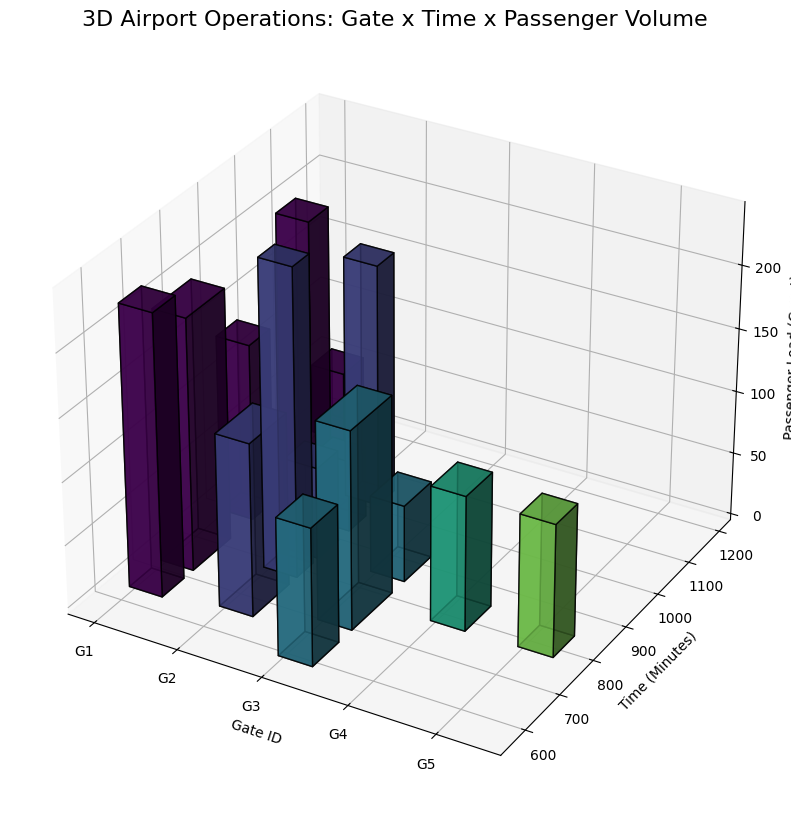

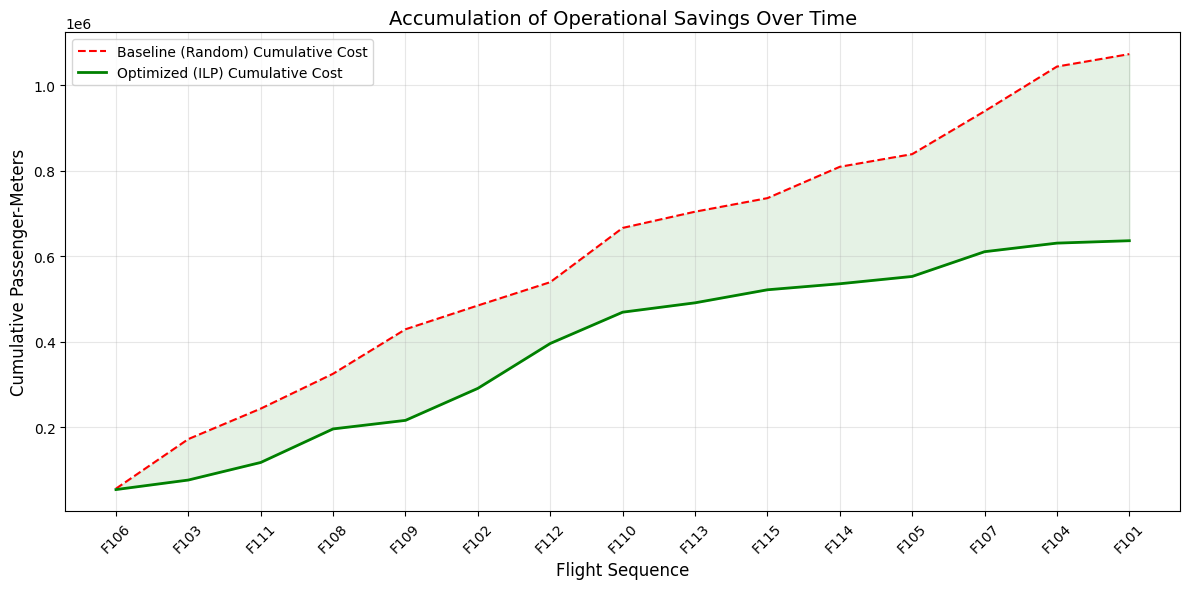

In [5]:
# 6. Advanced Visualization
# Transforming data into insights.

# Extract Schedule Data
schedule = []
for f in flights:
    for g in gates:
        if pulp.value(x[f][g]) == 1:
            row = df_flights[df_flights['Flight_ID'] == f].iloc[0]
            schedule.append({
                'Flight': f,
                'Gate': g,
                'Arrival': row['Arrival'],
                'Duration': row['Duration'],
                'Passengers': row['Passengers'],
                'Departure': row['Departure']
            })
df_schedule = pd.DataFrame(schedule)
df_schedule['Gate_Index'] = df_schedule['Gate'].apply(lambda x: int(x[1:]) - 1)

# --- Chart A: 3D Flight Operations Volume ---
# We visualize the schedule in 3D: Time x Gate x Passenger Volume
# This helps identifying which gates are handling the most 'load' (passengers).

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Data for 3D bars
# x = Gate Index, y = Arrival Time, z = 0 (base)
# dx = Gate Width, dy = Duration, dz = Passengers (Height)

for _, row in df_schedule.iterrows():
    x_pos = row['Gate_Index']
    y_pos = row['Arrival']
    z_pos = 0
    
    dx = 0.4
    dy = row['Duration']
    dz = row['Passengers']
    
    # Color bar based on gate (Visual distinction)
    color = plt.cm.viridis(row['Gate_Index'] / 5)
    
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=color, alpha=0.8, edgecolor='black')

ax.set_xlabel('Gate ID')
ax.set_ylabel('Time (Minutes)')
ax.set_zlabel('Passenger Load (Count)')
ax.set_xticks(range(5))
ax.set_xticklabels(['G1', 'G2', 'G3', 'G4', 'G5'])
ax.set_title("3D Airport Operations: Gate x Time x Passenger Volume", fontsize=16)

plt.show()

# --- Chart B: Cumulative Cost Reduction ---
# Visualizing how the savings accumulate flight by flight.

# Sort flights by arrival
df_viz = df_schedule.sort_values('Arrival').reset_index(drop=True)

# Calculate cumulative distance for Optimized vs Random (Expected)
df_viz['Optimized_Cost'] = df_viz['Passengers'] * df_viz['Gate'].apply(lambda g: df_gates[df_gates['Gate_ID']==g]['Distance_m'].values[0])
df_viz['Random_Cost'] = df_viz['Passengers'] * avg_gate_dist  # Expected random cost

df_viz['Cum_Optimized'] = df_viz['Optimized_Cost'].cumsum()
df_viz['Cum_Random'] = df_viz['Random_Cost'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_viz['Flight'], df_viz['Cum_Random'], label='Baseline (Random) Cumulative Cost', color='red', linestyle='--')
plt.plot(df_viz['Flight'], df_viz['Cum_Optimized'], label='Optimized (ILP) Cumulative Cost', color='green', linewidth=2)

plt.fill_between(df_viz['Flight'], df_viz['Cum_Optimized'], df_viz['Cum_Random'], color='green', alpha=0.1)

plt.title("Accumulation of Operational Savings Over Time", fontsize=14)
plt.ylabel("Cumulative Passenger-Meters", fontsize=12)
plt.xlabel("Flight Sequence", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

